In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import importlib
import transformer_type
from transformer_type.dataset import get_data
import torch
import pandas as pd

if torch.cuda.is_available(): device = torch.device ("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
# params = [120, 1, 64, 300, 32, 512, 2, 1e-5, 0.1]
# 120-1_64_32-2_1e-05_100
# params = {'input_window' : [120],
#          'pred_step' : [60],
#          'batch_size' : [64],
#          'epochs' : [100],
#          'feature_size' : [64],
#          'd_ff' : [32],
#          'num_layers' : [2],
#          'lr' : [1e-5],
#          'device' : [device],
#          'dropout' : [0.1],
#          'is_save' : [True]}

# best loss
# params = {'input_window' : [120],
#           'pred_step' : [60],
#          'batch_size' : [64],
#          'epochs' : [100],
#          'feature_size' : [128],
#          'd_ff' : [512],
#          'num_layers' : [2],
#          'lr' : [1e-5],
#          'device' : [device],
#          'dropout' : [0.1],
#          'is_save' : [True]}

params = {'input_window' : [120],
          'pred_step' : [60],
         'batch_size' : [60],
         'epochs' : [100],
         'feature_size' : [128, 256],
         'd_ff' : [1024, 2048],
         'num_layers' : [4, 5],
         'lr' : [1e-5],
         'device' : [device],
         'dropout' : [0.1],
         'is_save' : [True],
         'diff' : [True],
         'mean_std' : [True],}



# params = {'input_window' : [60],
#           'pred_step' : [60],
#          'batch_size' : [64],
#          'epochs' : [10],
#          'feature_size' : [16],
#          'd_ff' : [16],
#          'num_layers' : [1],
#          'lr' : [1e-5],
#          'device' : [device],
#          'is_save' : [True],
#          'diff' : [True],
#          'mean_std' : [True]}

In [3]:
DATA_PATH = "../../data/kaggle_data/"

In [4]:
params['mean_std'][0]

True

In [5]:

# make dataset

def data_extract(df_dict, df, name, cols):
       for col in cols:
              df_dict[f"{name}_{col}"] = df.loc[df[col] != 0, col]
       return df_dict

train_data_list = []
val_data_list = []


# rom_df = pd.read_csv(DATA_PATH + "romania_elec_daily.csv")
# rom_cols = ['Consumption']
pmj_df = pd.read_csv(DATA_PATH + "pjm_elec_daily.csv")
pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW'] # 'PJM_Load', 'EKPC'
# pmj_cols = ['DUQ']

# ind_df = pd.read_csv(DATA_PATH + "india_elec_daily.csv")
# ind_cols = ['Punjab', 'Haryana', 'Rajasthan', 'Delhi', 'UP',
#        'Uttarakhand', 'HP', 'J&K', 'Chandigarh', 'Chhattisgarh', 'Gujarat',
#        'MP', 'Maharashtra', 'Goa', 'DNH', 'Andhra Pradesh', 'Telangana',
#        'Karnataka', 'Kerala', 'Tamil Nadu', 'Pondy', 'Bihar', 'Jharkhand',
#        'Odisha', 'West Bengal', 'Sikkim', 'Arunachal Pradesh', 'Assam',
#        'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
# mal_df = pd.read_csv(DATA_PATH + "malaysia_elec_daily.csv")
# mal_cols = ['load']
# tet_df = pd.read_csv(DATA_PATH + "tetouan_elec_daily.csv")
# tet_cols = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']
# steel_df = pd.read_csv(DATA_PATH + "steel_industry_elec_daily.csv")
# steel_cols = ['Usage_kWh']

df_dict = {}

# df_dict = data_extract(df_dict, rom_df, 'ROM', rom_cols)
df_dict = data_extract(df_dict, pmj_df, 'PMJ', pmj_cols)

# df_dict = data_extract(df_dict, mal_df, 'MAL', mal_cols)
# df_dict = data_extract(df_dict, ind_df, 'IND', ind_cols)
# df_dict = data_extract(df_dict, tet_df, 'TET', tet_cols)
# df_dict = data_extract(df_dict, steel_df, 'STEEL', steel_cols)

for df_name in df_dict:
    df = df_dict[df_name]
    train_data, val_data, scaler = get_data(df,
                                            params['input_window'][0],
                                            1,
                                            scaler_name='mm',
                                            diff=params['diff'][0],
                                            mean_std=params['mean_std'][0])
    train_data = train_data.to(device)
    val_data = val_data.to(device)
    print(df_name, len(train_data), len(val_data))
    train_data_list.append((train_data, df_name, scaler))
    val_data_list.append((val_data, df_name, scaler))
    break

PMJ_AEP 3923 890


In [6]:
def get_new_data(data, split_idx=None):
    new_data = []
    if split_idx == None:
        split_idx = []
        for i, val in enumerate(train_data[0][0]):
            if val == -100:
                split_idx.append(i)

    for i, d in enumerate(data):
        new_row = []

        for data_tmp in d:
            data_tmp = data_tmp.tolist()
            src = data_tmp[split_idx[1]+1:split_idx[2]]
            # mean = data[split_idx[0] + 1]
            # std = data[split_idx[1] + 1]
            tgt = data_tmp[split_idx[2]+1 + 1:]
            new_row.append([src, tgt])

        new_data.append(new_row)
    
    return torch.Tensor(new_data)

In [7]:
new_train_data_list = {}

for train_data, t, scaler in train_data_list:
    new_train_data_list[t] = (get_new_data(train_data), scaler[0], scaler[1])

print(new_train_data_list[t][0].shape)

new_val_data_list = {}

for val_data, t, scaler in val_data_list:
    new_val_data_list[t] = (get_new_data(val_data), scaler[0], scaler[1])

print(new_val_data_list[t][0].shape)

torch.Size([3923, 2, 2, 119])
torch.Size([890, 2, 2, 119])


In [8]:
from torch import nn
import math

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

def inverse_scaling(value, scaler):
    if scaler is not None:
        return float(scaler.inverse_transform(value.cpu().detach().reshape(1, -1)))
    else:
        return value.cpu().detach().reshape(1, -1)

In [28]:
import time, math
# from transformer_type.model import TransformerFull
from transformer_type.dataset import get_batch

calculate_loss_over_all_values = False

def train_epoch(model, train_data, type, epoch, optimizer, scheduler, criterion, batch_size, input_window, output_window, RESULT_TXT_PATH):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, label = get_batch(train_data, i, batch_size, input_window + output_window)
        src, tgt = data
        src, tgt = src[:-1], tgt[:-1]
        src, tgt = src.reshape(-1, src.size(0), 1).to(device), tgt.reshape(-1, tgt.size(0), 1).to(device)
        targets = label[1].reshape(label[0].size(0), -1, 1).to(device)
        optimizer.zero_grad()
        output = model(src, tgt)
        if calculate_loss_over_all_values:
            loss = criterion(output, targets[1:])
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
        # loss = torch.sqrt(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            with open(RESULT_TXT_PATH, 'a') as f:
                f.write('{} | epoch {:3d} | {:5d}/{:5d} batches | lr {:02.6f} | {:5.2f} ms | loss {:5.5f} | ppl {:8.2f}\n'.format(
                        type, epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                        elapsed * 1000 / log_interval,
                        cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    return model, optimizer, scheduler, loss.item()



class TransformerFull(nn.Module):
    # Constructor
    def __init__( self, num_tokens=1, dim_model=512, num_heads=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout_p=0.1, ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(d_model=dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)
        self.out2 = nn.Linear(num_tokens, 1)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src, Tgt size 는 반드시 (batch_size, src sequence length) 여야 합니다.


        if tgt_mask is None:
            device = src.device
            mask = self.get_tgt_mask(tgt.size(1)).to(device)
            tgt_mask = mask
        
        if src_pad_mask is None:
            device = src.device
            mask = self.create_pad_mask(src.squeeze(), 0).to(device)
            src_pad_mask = mask

        if tgt_pad_mask is None:
            device = src.device
            mask = self.create_pad_mask(tgt.squeeze(), 0).to(device)
            tgt_pad_mask = mask

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        # print(transformer_out.shape)
        out = self.out(transformer_out)
        # out = self.out2(out)
        # print(out.shape)
        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)

In [29]:
from torch import nn
model = TransformerFull(
    dim_model=128,
    num_heads=16,
    num_encoder_layers=1,
    num_decoder_layers=5,
    dim_feedforward=1024
).to(device)

epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
criterion = nn.MSELoss()
batch_size = 4
input_window = params['input_window'][0]
output_window = 1
RESULT_TXT_PATH = "transformer_results/full_test"

loss_list = []

for epoch in tqdm(range(epochs)):
    # model = model.to(device)
    model.train()
    for t in new_train_data_list:
        train_data, scaler, diff_scaler = new_train_data_list[t]
        model, optimizer, scheduler, loss = train_epoch(
            model=model,
            train_data=train_data,
            type=t,
            epoch=epoch,
            optimizer=optimizer,
            scheduler=scheduler,
            criterion=criterion,
            batch_size=batch_size,
            input_window=input_window,
            output_window=output_window,
            RESULT_TXT_PATH=RESULT_TXT_PATH)
        
        loss_list.append(loss)

    if epoch % 10 == 0:
        print(loss)

        # for i in tqdm(range(len(val_data) - pred_seq)):
        plt.figure(figsize=(20, 15))
        sub_num = 1
        for t in new_val_data_list:
            new_val_data, scaler, diff_scaler = new_val_data_list[t]
            pred_seq=20
            cur_values = {}
            predictions = {}
            true_values = {}
            input_window, output_window = params['input_window'][0], 1

            predictions_period = {}
            true_values_period = {}
            cur_values_period = {}

            model.eval()
            cur_values[t] = []
            predictions[t] = []
            true_values[t] = []

            predictions_period[t] = []
            true_values_period[t] = []
            cur_values_period[t] = []

            for i in range(1):
                # data = val_data[i][0][:-1].reshape(-1, 1, 1)
                data, tgt = new_val_data[i][0]
                data, tgt = data[:-1].reshape(-1, data.size(0)-1, 1), tgt[:-1].reshape(-1, tgt.size(0)-1, 1)
                data, tgt = data.to(device), tgt.to(device)

                cur_values[t].append(float(inverse_scaling(val_data[i][1][-1], scaler)))
                cur_values_period[t].append([float(inverse_scaling(val_data[i][1][-1], scaler))] * pred_seq)
                for _ in range(pred_seq):
                    output = model(data[-input_window:], tgt[-input_window:])
                    # plt.plot([inverse_scaling(o, scaler) for o in list(output.squeeze()[-pred_seq:])])
                    data = torch.cat(
                        (
                            # torch.Tensor([.0]).to(device),
                            data.squeeze()[:],
                            torch.Tensor(
                                diff_scaler.transform(
                                    (
                                        output.squeeze()[-1] - tgt.squeeze()[-1]
                                    ).cpu().detach().numpy().reshape(-1, 1)
                                )
                            ).squeeze().to(device).unsqueeze(0)
                            # (output.squeeze()[-1] - tgt.squeeze()[-1]).unsqueeze(0)
                        )
                        ).resize(1, data.size(1) + 1, 1)
                    
                    tgt = torch.cat(
                        (
                            tgt.squeeze()[:],
                            output.squeeze()[-1].unsqueeze(0),
                            # torch.Tensor([.0]).to(device)
                        )
                        ).resize(1, tgt.size(1) + 1, 1)
                    
                predictions[t].append(float(inverse_scaling(output[-1], scaler)))
                true_values[t].append(float(inverse_scaling(new_val_data[i + pred_seq][1][1][-1], scaler)))
                predictions_period[t].append([inverse_scaling(d, scaler) for d in list(tgt.squeeze()[-pred_seq:])])
                true_values_period[t].append([inverse_scaling(d, scaler) for d in list(new_val_data[i + input_window][1][1][:pred_seq])])

            plt.subplot(len(new_val_data_list) // 2 + 1, 2, sub_num)
            plt.rc('font', size=10)
            plt.plot(predictions_period[t][0], label='prediction')
            plt.plot(true_values_period[t][0], label="GT")
            
            sub_num += 1
            # plt.show()
        plt.legend()
        plt.savefig(f'./transformer_results/full_test_{epoch}.png')

  0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: For batched (3-D) `query`, expected `key_padding_mask` to be `None` or 2-D but found 1-D tensor instead

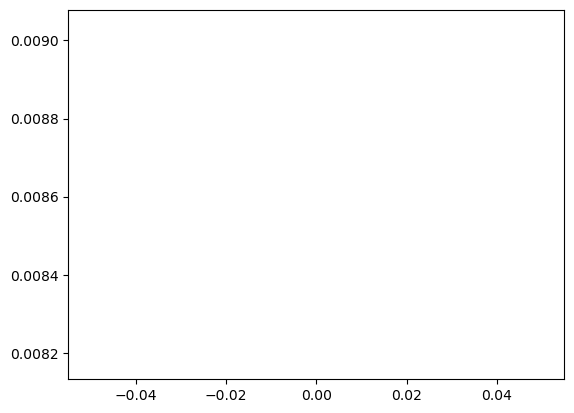

In [ ]:
plt.plot(loss_list)

In [18]:
data.squeeze().cpu().detach().numpy()

array([-2.88413912e-01,  3.20062459e-01, -8.86082351e-01, -6.17703497e-01,
        9.54685926e-01,  8.76730010e-02, -2.41430894e-01,  2.02474967e-01,
       -3.33019912e-01, -9.88367856e-01,  2.74490803e-01,  1.70771396e+00,
       -5.79708576e-01, -1.58607095e-01, -2.72032339e-02,  1.19428314e-01,
       -6.75234497e-01, -3.87579620e-01,  1.23959231e+00, -4.35379714e-01,
       -3.65555167e-01, -8.30257311e-02,  8.04191709e-01, -4.46113378e-01,
        6.55742809e-02,  1.67892992e+00, -5.73506057e-01, -1.84033883e+00,
       -1.45998073e+00, -1.07870372e-02,  3.19951057e-01,  2.49569386e-01,
        1.85891378e+00, -1.56007245e-01,  2.84335595e-02,  8.89689684e-01,
        2.04220578e-01, -9.25822914e-01, -4.32185620e-01,  7.73736358e-01,
       -2.87745357e-01,  1.23736642e-01, -6.70146167e-01, -7.03610003e-01,
       -1.37503982e+00, -2.37271130e-01,  1.40067160e+00,  4.87529963e-01,
        3.85729745e-02,  1.66039914e-01,  1.16638803e+00, -3.94822061e-01,
       -5.01193047e-01,  

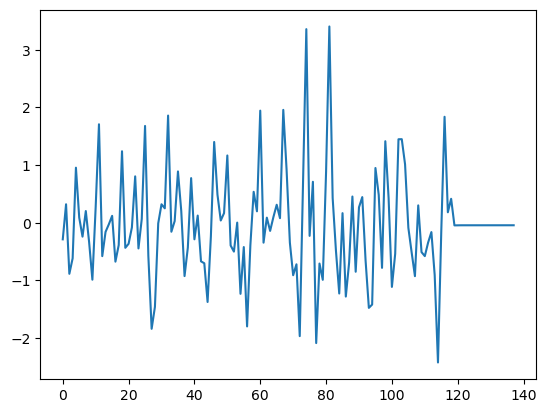

In [19]:
plt.plot(data.squeeze().cpu().detach().numpy())

In [20]:
tgt.squeeze().detach().cpu()

tensor([0.5898, 0.5473, 0.5183, 0.5687, 0.5753, 0.5653, 0.5777, 0.5631, 0.5154,
        0.5315, 0.6198, 0.5928, 0.5869, 0.5878, 0.5960, 0.5641, 0.5467, 0.6115,
        0.5917, 0.5754, 0.5734, 0.6162, 0.5959, 0.6014, 0.6883, 0.6615, 0.5709,
        0.4994, 0.5010, 0.5194, 0.5341, 0.6301, 0.6245, 0.6281, 0.6752, 0.6877,
        0.6431, 0.6235, 0.6647, 0.6524, 0.6609, 0.6292, 0.5959, 0.5287, 0.5189,
        0.5918, 0.6186, 0.6227, 0.6333, 0.6943, 0.6766, 0.6535, 0.6558, 0.5957,
        0.5766, 0.4880, 0.4706, 0.4998, 0.5120, 0.6123, 0.5970, 0.6037, 0.5987,
        0.6058, 0.6238, 0.6300, 0.7309, 0.7796, 0.7644, 0.7206, 0.6864, 0.5893,
        0.6286, 0.8002, 0.7909, 0.8289, 0.7257, 0.6922, 0.6444, 0.6910, 0.8650,
        0.8889, 0.8666, 0.8068, 0.8174, 0.7549, 0.7222, 0.7473, 0.7065, 0.7222,
        0.7469, 0.7161, 0.6438, 0.5743, 0.6244, 0.6509, 0.6136, 0.6872, 0.7109,
        0.6569, 0.6319, 0.7072, 0.7825, 0.8358, 0.8335, 0.8097, 0.7651, 0.7825,
        0.7589, 0.7319, 0.7167, 0.7107, 

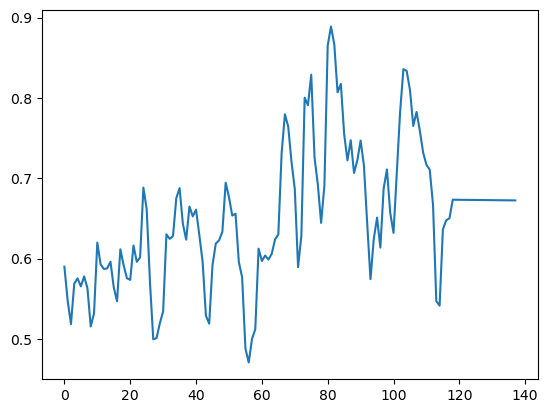

In [21]:
plt.plot(tgt.squeeze().detach().cpu())

In [22]:
output.squeeze().cpu().detach().numpy()

array([0.6723585 , 0.6723589 , 0.672359  , 0.67235875, 0.67235875,
       0.67235875, 0.67235875, 0.67235863, 0.672359  , 0.672359  ,
       0.6723584 , 0.67235863, 0.67235863, 0.67235863, 0.6723585 ,
       0.67235875, 0.67235875, 0.6723585 , 0.67235863, 0.67235875,
       0.67235875, 0.6723584 , 0.67235863, 0.6723585 , 0.6723578 ,
       0.67235816, 0.67235863, 0.6723592 , 0.67235935, 0.672359  ,
       0.6723589 , 0.6723584 , 0.6723583 , 0.6723583 , 0.67235804,
       0.6723579 , 0.6723583 , 0.6723584 , 0.67235816, 0.67235804,
       0.67235804, 0.6723583 , 0.67235863, 0.672359  , 0.672359  ,
       0.67235863, 0.6723584 , 0.6723584 , 0.6723583 , 0.6723579 ,
       0.67235804, 0.67235804, 0.67235816, 0.67235863, 0.6723589 ,
       0.6723592 , 0.67235935, 0.6723592 , 0.6723592 , 0.6723584 ,
       0.6723585 , 0.6723585 , 0.67235863, 0.6723585 , 0.6723584 ,
       0.6723584 , 0.6723577 , 0.6723573 , 0.67235756, 0.6723577 ,
       0.6723578 , 0.67235863, 0.6723584 , 0.6723572 , 0.67235

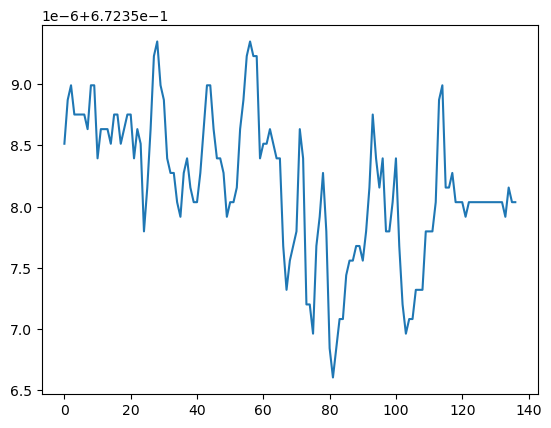

In [23]:
plt.plot(output.squeeze().cpu().detach().numpy())

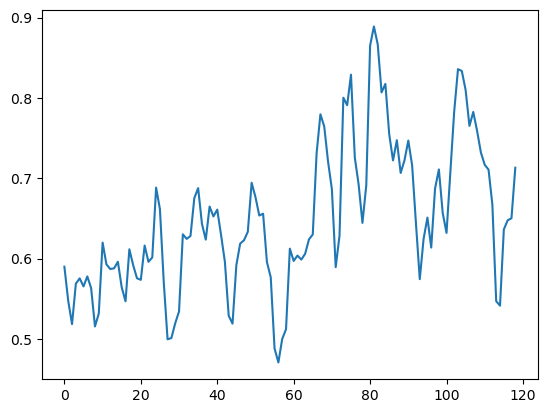

In [ ]:
plt.plot(new_val_data[i][1][1])

In [ ]:
tgt.squeeze(), new_val_data[i + input_window][1][1]

(tensor([0.5898, 0.5473, 0.5183, 0.5687, 0.5753, 0.5653, 0.5777, 0.5631, 0.5154,
         0.5315, 0.6198, 0.5928, 0.5869, 0.5878, 0.5960, 0.5641, 0.5467, 0.6115,
         0.5917, 0.5754, 0.5734, 0.6162, 0.5959, 0.6014, 0.6883, 0.6615, 0.6703,
         0.6706, 0.6708, 0.6710, 0.6712, 0.6714, 0.6716, 0.6717, 0.6719, 0.6720,
         0.6721, 0.6722, 0.6723, 0.6724, 0.6725, 0.6726, 0.6727, 0.6728, 0.6729,
         0.6729], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([0.5010, 0.5194, 0.5341, 0.6301, 0.6245, 0.6281, 0.6752, 0.6877, 0.6431,
         0.6235, 0.6647, 0.6524, 0.6609, 0.6292, 0.5959, 0.5287, 0.5189, 0.5918,
         0.6186, 0.6227, 0.6333, 0.6943, 0.6766, 0.6535, 0.6558, 0.5957, 0.5766]))

In [ ]:
predictions_period

{'PMJ_AEP': [[372448.116396904,
   372616.3779332638,
   372731.6582336426,
   372836.06243395805,
   372935.41020178795,
   373027.7298464775,
   373116.13791131973,
   373198.2810881138,
   373274.222979784,
   373344.7268214226,
   373410.3650393486,
   373471.42384672165,
   373528.3802654743,
   373581.7431190014,
   373631.7986204624,
   373678.61037278175,
   373722.6235964298,
   373764.0291001797,
   373803.14489865303,
   373838.3809187412]]}

In [ ]:
tgt.squeeze()[:-pred_seq], tgt.squeeze()[-pred_seq:]

(tensor([0.5898, 0.5473, 0.5183, 0.5687, 0.5753, 0.5653, 0.5777, 0.5631, 0.5154,
         0.5315, 0.6198, 0.5928, 0.5869, 0.5878, 0.5960, 0.5641, 0.5467, 0.6115,
         0.5917, 0.5754, 0.5734, 0.6162, 0.5959, 0.6014, 0.6883, 0.6615],
        device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([0.6703, 0.6706, 0.6708, 0.6710, 0.6712, 0.6714, 0.6716, 0.6717, 0.6719,
         0.6720, 0.6721, 0.6722, 0.6723, 0.6724, 0.6725, 0.6726, 0.6727, 0.6728,
         0.6729, 0.6729], device='cuda:0', grad_fn=<SliceBackward0>))

In [ ]:
tgt.squeeze().shape, new_val_data[i][1][1].shape

(torch.Size([46]), torch.Size([27]))

In [ ]:
tgt.squeeze(), new_val_data[i][1][1]

(tensor([0.5898, 0.5473, 0.5183, 0.5687, 0.5753, 0.5653, 0.5777, 0.5631, 0.5154,
         0.5315, 0.6198, 0.5928, 0.5869, 0.5878, 0.5960, 0.5641, 0.5467, 0.6115,
         0.5917, 0.5754, 0.5734, 0.6162, 0.5959, 0.6014, 0.6883, 0.6615, 0.6703,
         0.6706, 0.6708, 0.6710, 0.6712, 0.6714, 0.6716, 0.6717, 0.6719, 0.6720,
         0.6721, 0.6722, 0.6723, 0.6724, 0.6725, 0.6726, 0.6727, 0.6728, 0.6729,
         0.6729], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([0.5898, 0.5473, 0.5183, 0.5687, 0.5753, 0.5653, 0.5777, 0.5631, 0.5154,
         0.5315, 0.6198, 0.5928, 0.5869, 0.5878, 0.5960, 0.5641, 0.5467, 0.6115,
         0.5917, 0.5754, 0.5734, 0.6162, 0.5959, 0.6014, 0.6883, 0.6615, 0.5709]))

In [ ]:
# type_120-120_32_64-512-2_0.0005_200_0.1
# type_120-120_32_128-256-2_0.0005_200_0.1
# type_120-120_32_128-512-2_0.0005_200_0.1
# type_120-120_32_128-1024-2_0.0005_200_0.1

In [ ]:
def inverse_scaling(value, scaler):
    return float(scaler.inverse_transform(value.cpu().detach().reshape(1, -1)))

In [ ]:
pred_seq=60
cur_values = {}
predictions = {}
true_values = {}
input_window, output_window = 120, 1

predictions_period = {}
true_values_period = {}
cur_values_period = {}

_, t, (scaler, _) = val_data_list[0]
new_val_data
model = model.to(device)
model.eval()
cur_values[t] = []
predictions[t] = []
true_values[t] = []

predictions_period[t] = []
true_values_period[t] = []
cur_values_period[t] = []

# for i in tqdm(range(len(val_data) - pred_seq)):
for i in tqdm(range(20)):
    # data = val_data[i][0][:-1].reshape(-1, 1, 1)
    data, tgt = new_val_data[i][0]
    data, tgt = data.reshape(-1, data.size(0), 1), tgt.reshape(-1, tgt.size(0), 1)
    data, tgt = data.to(device), tgt.to(device)

    for _ in range(pred_seq):
        output = model(data[-input_window:], tgt[-input_window:])
        data = torch.cat((torch.Tensor([.0]).to(device), data.squeeze()[2:], (output.squeeze()[-1] - data.squeeze()[-1]).unsqueeze(0))).resize(1, data.size(1), 1)
        tgt = torch.cat((tgt.squeeze()[1:-1], output.squeeze()[-1].unsqueeze(0), torch.Tensor([.0]).to(device))).resize(1, tgt.size(1), 1)
        
    predictions[t].append(float(scaler.inverse_transform(output[-1].cpu().detach().reshape(1, -1))))
    true_values[t].append(float(scaler.inverse_transform(new_val_data[i][1][1][-1].cpu().detach().reshape(1, -1))))

    predictions_period[t].append([inverse_scaling(d, scaler) for d in list(tgt.squeeze()[:-1])])
    true_values_period[t].append([inverse_scaling(d, scaler) for d in list(new_val_data[i + pred_seq][1][1][:-1])])

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
print(new_val_data[0][1][1])
print(new_val_data[1][1][1])
print(new_val_data[2][1][1])

tensor([0.5898, 0.5473, 0.5183, 0.5687, 0.5753, 0.5653, 0.5777, 0.5631, 0.5154,
        0.5315, 0.6198, 0.5928, 0.5869, 0.5878, 0.5960, 0.5641, 0.5467, 0.6115,
        0.5917, 0.5754, 0.5734, 0.6162, 0.5959, 0.6014, 0.6883, 0.6615, 0.5709])
tensor([0.5473, 0.5183, 0.5687, 0.5753, 0.5653, 0.5777, 0.5631, 0.5154, 0.5315,
        0.6198, 0.5928, 0.5869, 0.5878, 0.5960, 0.5641, 0.5467, 0.6115, 0.5917,
        0.5754, 0.5734, 0.6162, 0.5959, 0.6014, 0.6883, 0.6615, 0.5709, 0.4994])
tensor([0.5183, 0.5687, 0.5753, 0.5653, 0.5777, 0.5631, 0.5154, 0.5315, 0.6198,
        0.5928, 0.5869, 0.5878, 0.5960, 0.5641, 0.5467, 0.6115, 0.5917, 0.5754,
        0.5734, 0.6162, 0.5959, 0.6014, 0.6883, 0.6615, 0.5709, 0.4994, 0.5010])


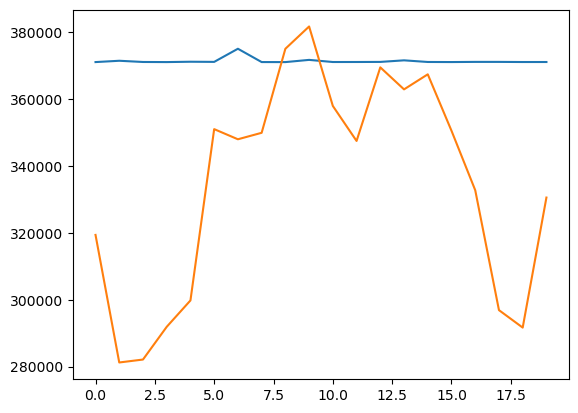

In [ ]:
plt.plot(predictions[t])
plt.plot(true_values[t])

tensor(0.1198)


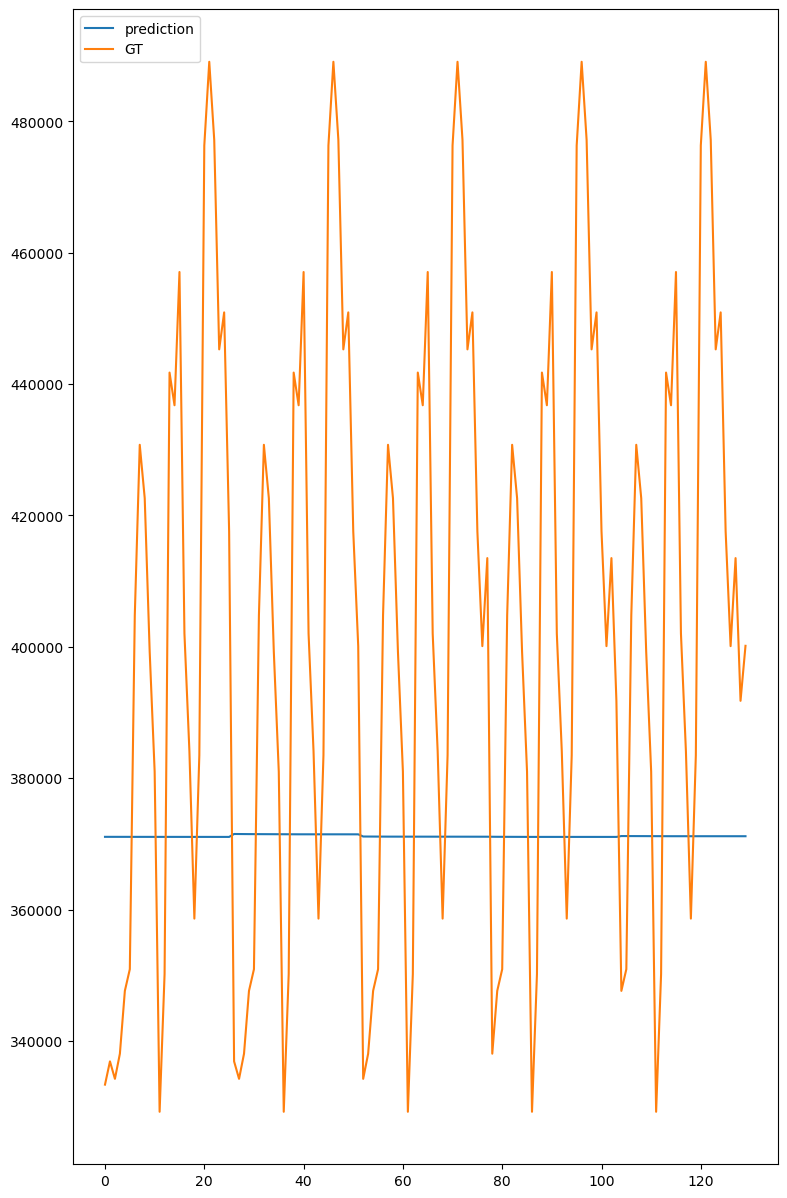

In [ ]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE, MeanAbsolutePercentageError as MAPE, R2Score as R2
import matplotlib.pyplot as plt

# tensor(0.0757)
# tensor(0.1433)
# tensor(0.2411)
# tensor(0.1079)
# tensor(0.2570)
# tensor(0.1562)
# tensor(0.1002)
# tensor(0.2347)
# tensor(0.1141)
# tensor(0.2481)

smape = SMAPE()
idx = 0
sub_num = 1
plt.figure(figsize=(20, 15 * len(predictions_period) // len(val_data_list)))
for t in predictions_period:
    pred, true_val = [], []
    for p, gt in zip(predictions_period[t][idx : idx + 5], true_values_period[t][idx : idx + 5]):
        pred += p[-pred_seq:]
        true_val += gt[-pred_seq:]
    plt.subplot(len(predictions_period) // 2 + 1, 2, sub_num)
    plt.rc('font', size=10)
    plt.plot(pred, label='prediction')
    plt.plot(true_val, label="GT")
    print(smape(torch.tensor(pred), torch.tensor(true_val)))

    sub_num += 1

plt.legend()
plt.show()